In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np

import jax.numpy as jnp

import h5py

import corner

import gw_pop_numpyro

import seaborn as sns

In [2]:
from gw_pop_numpyro import config, setup_injections_PE, numpyro_sample, popmodels, postproc, plot_helper

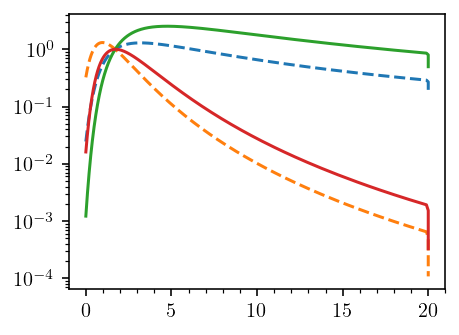

In [3]:
from gw_pop_numpyro import distributions as dist

tL_plot = np.linspace(0, 13.7, 1000)*1e3
z_plot = config.cosmo_dict["z_at_lookback_time"](tL_plot)
y = dist.rate_lookbacktime(tL_plot, 1, 5e-4, config.cosmo_dict)
y2 = dist.rate_lookbacktime(tL_plot, 3, 5e-4, config.cosmo_dict)

plt.plot(z_plot, y, ls = '--')
plt.plot(z_plot, y2, ls = '--')

y = dist.rate_lookbacktime(tL_plot, 1, 8e-4, config.cosmo_dict)
y2 = dist.rate_lookbacktime(tL_plot, 3, 8e-4, config.cosmo_dict)

plt.plot(z_plot, y)
plt.plot(z_plot, y2)

plt.yscale('log')

### Prior

In [9]:
prior = numpyro_sample.get_prior_function(pop_model, config.DEFAULT_HYPERPRIOR) 

prior_sampler, prior_samples = numpyro_sample.sample_from_posterior(prior, num_warmup = 1000, num_samples = 1000, progress_bar = True)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 286.51it/s, 7 steps of size 5.18e-01. acc. prob=0.90]


Text(0.5, 1.0, 'PRIOR')

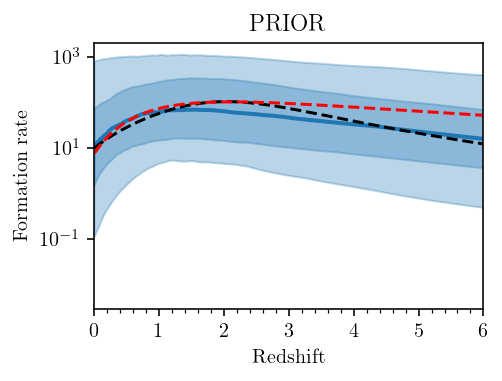

In [20]:
prior_samples["rate_N"] = np.exp(7 + 6 * np.random.random(1000))

Rfs_prior = formation_rate_at_tL_samps(prior_samples, tL_forms)

fig, ax = plt.subplots(constrained_layout=True)

xs = config.cosmo_dict["z_at_lookback_time"](tL_forms)

plot_helper.plot_bands(ax, xs, 1e9 * Rfs_prior, plot_kwargs = dict(linewidth = 2.0))

ax.plot(xs, 10 * dist.redshift_peak(xs, a = 2.6, b = 6.2-2.6, zp = 2.2, zmax = 20), ls = '--', c = 'k')

ax.plot(xs, 100 * dist.rate_lookbacktime(tL_forms, 1.34, 0.43 * 1e-3, config.cosmo_dict), ls = '--', c = 'r')


ax.set_yscale('log')

ax.set_xlim(0, 6)

ax.set_xlabel('Redshift')

ax.set_ylabel('Formation rate')

plt.title('PRIOR')

Text(0.5, 1.0, 'efficiency PRIOR')

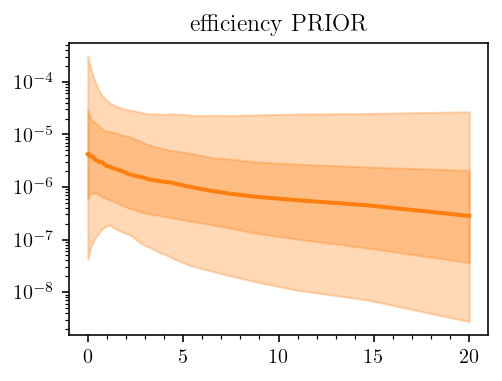

In [21]:
efficiency_prior = Rfs_prior * 30 / dist.rate_lookbacktime(tL_forms, 1.34, 0.43 * 1e-3, config.cosmo_dict)

fig, ax = plt.subplots(constrained_layout=True)

plot_helper.plot_bands(ax, xs, efficiency_prior, plot_kwargs = dict(linewidth = 2.0), color = sns.color_palette()[1])

ax.set_yscale('log')

plt.title('efficiency PRIOR')

### Read in PE and injections

In [4]:
PEsamples, events = setup_injections_PE.preprocess_PE(**config.default_PE_settings)
inj, Ndraw,  Tobs_years = setup_injections_PE.preprocess_injections(**config.default_injection_settings)

### "Default" delay time model 
(power law with minimum 20 Myr and slope -1) 

Draw the delay times, and add in formation times to PEsamples and inj dicts, as well as tau_grid and ptau_grid.

In [5]:
from delay_time_helper import ptau, draw_delay_times, add_formation_tL

In [6]:
add_formation_tL(samples = PEsamples, tmin = 20)
add_formation_tL(samples = inj, tmin = 20)

In [7]:
pop_model = popmodels.bandpass_plpeak_mass_formation_time_Gaussian_chieff_dist

pop_model._param_names

['mmin',
 'mmax',
 'alpha1',
 'fpeak',
 'mupeak',
 'sigpeak',
 'n1',
 'n2',
 'beta',
 'at',
 'bt',
 'mu',
 'sig']

In [8]:
tL_forms = np.linspace(1, config.cosmo_dict["age_of_universe"], 100)


def formation_rate_at_tL_samps(hypersamps, tL_forms):
    
    zmerge_grid = jnp.linspace(0, config.zmerge_max, 1000)
    
    hyper_keys = pop_model._param_names

    nhyper = len(hypersamps[hyper_keys[0]])
    
    Rfs = np.zeros((nhyper, len(tL_forms)))
    
    for i in range(nhyper):
        
        pop = pop_model(**{key: hypersamps[key][i] for key in hyper_keys})
    
        log_Rf = jnp.log(hypersamps["rate_N"][i]) + pop.log_Vct_dist(tL_forms) - pop.logznorm(zmerge_grid, PEsamples["tau_grid"], PEsamples["ptau_grid"])
                
        Rfs[i, :] = jnp.exp(log_Rf)
    
    return Rfs

In [14]:
posterior_func = numpyro_sample.get_posterior_function(pop_model, prior, PEsamples, inj, Ndraw)

sampler, samples = numpyro_sample.sample_from_posterior(posterior_func, num_warmup = 2000, num_samples = 2000, progress_bar = True)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [14:05<00:00,  4.73it/s, 15 steps of size 2.15e-01. acc. prob=0.91]


In [15]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha1     -3.35      0.40     -3.38     -4.04     -2.76    645.66      1.00
        at      1.77      0.56      1.67      1.00      2.63   2038.77      1.00
      beta      2.30      1.37      2.09      0.14      4.43    937.47      1.00
        bt      0.00      0.00      0.00      0.00      0.00   1883.70      1.00
     fpeak      0.00      0.00      0.00      0.00      0.00    707.45      1.00
      mmax     65.34     12.83     69.05     43.78     79.99    625.15      1.00
      mmin      7.94      0.87      8.02      6.64      9.32   1244.34      1.00
        mu      0.06      0.02      0.06      0.03      0.08   1452.47      1.00
    mupeak     34.64      1.33     34.71     32.84     36.86    676.35      1.00
        n1     14.58      3.76     15.16      9.20     19.98   2943.14      1.00
        n2      8.49      5.46      7.12      2.00     17.08   1184.66      1.00
       sig      0.08      0

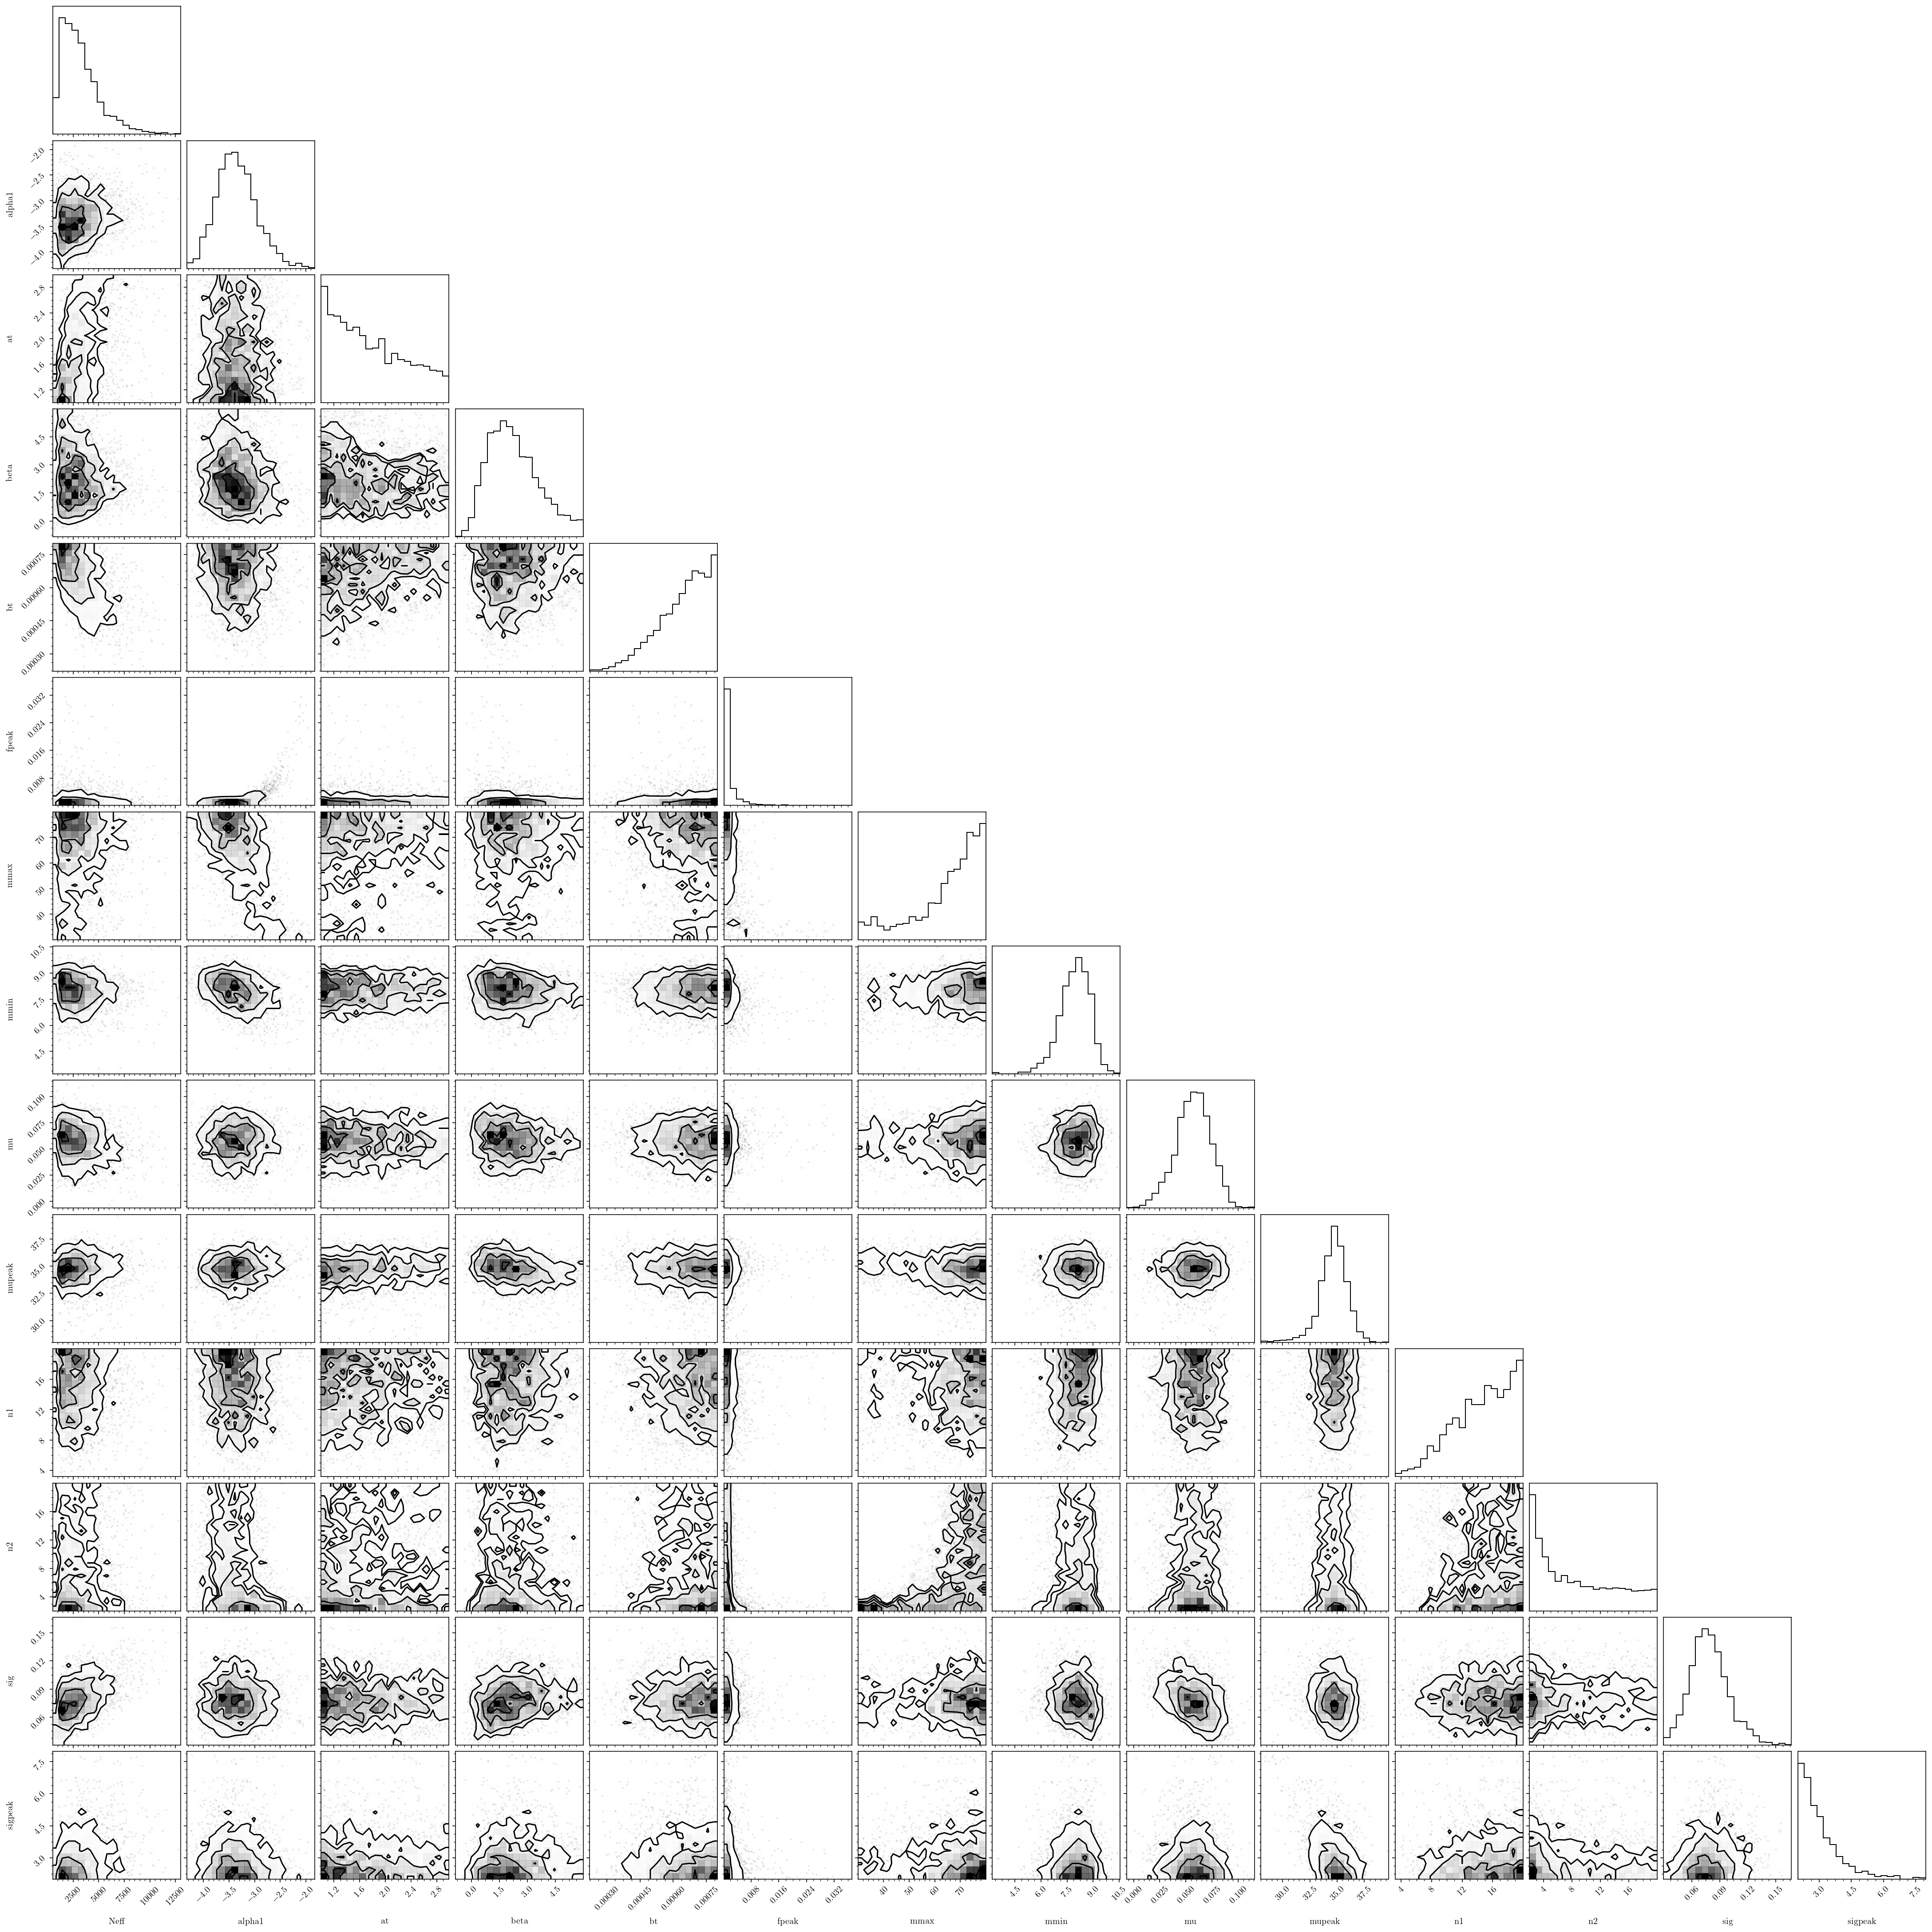

In [16]:
corner.corner(samples);

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


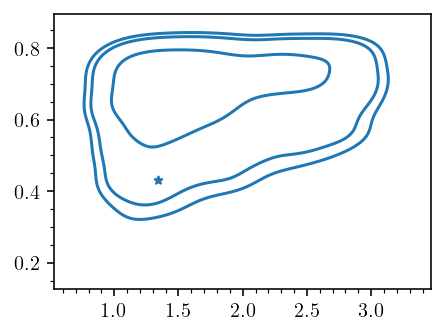

In [17]:
sns.kdeplot(samples['at'], samples['bt']*1e3, levels = [0.05, 0.1, 0.5])
plt.scatter(1.34, 0.43, marker = '*')
plt.show()

In [18]:
with h5py.File('formation_time_hypersamples.h5', 'w') as out:
    for key in samples.keys():
        out.create_dataset(name = key, data = samples[key])

In [12]:
hypersamps = dict()

with h5py.File('formation_time_hypersamples.h5', 'r') as inp:
    for key in inp.keys():
        hypersamps[key] = np.array(inp[key])

In [13]:
hypersamps = postproc.save_lognorm(hypersamps, pop_model, lognorm_kwargs = dict(tau_grid = PEsamples["tau_grid"], ptau_grid = PEsamples["ptau_grid"]))

In [14]:
hypersamps = postproc.save_rate_N(hypersamps, inj, Ndraw, Tobs_years, len(events), pop_model)

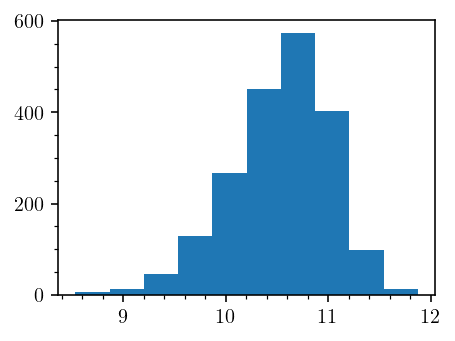

In [24]:
plt.hist(np.log(hypersamps["rate_N"]))
plt.show()

In [15]:
hypersamps.keys()

dict_keys(['Neff', 'alpha1', 'at', 'beta', 'bt', 'fpeak', 'mmax', 'mmin', 'mu', 'mupeak', 'n1', 'n2', 'sig', 'sigpeak', 'lognorm', 'rate_N'])

In [16]:
Rfs = formation_rate_at_tL_samps(hypersamps, tL_forms)

In [17]:
m1_grid = np.linspace(2, 100, 100)
m2_grid = np.linspace(2, 100, 100)
average_Mtot = postproc.compute_average_Mtot(m1_grid, m2_grid, hypersamps, pop_model)

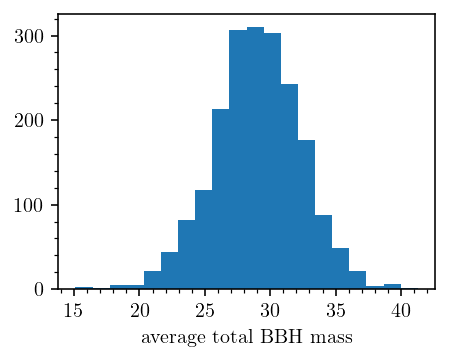

In [18]:
plt.hist(average_Mtot, bins = 20)
plt.xlabel('average total BBH mass')
plt.show()

In [22]:
with h5py.File('formation_rate_vs_tL.h5', 'w') as out:
    out.create_dataset(name = 'tL_forms', data = tL_forms)
    out.create_dataset(name = 'Rf_posterior', data = Rfs)
    out.create_dataset(name = 'Mtot_average', data = average_Mtot)
    out.create_dataset(name = 'Rf_prior', data = Rfs_prior)

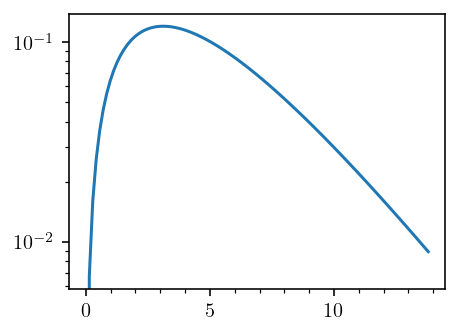

In [31]:
Ts = config.cosmo_dict["age_of_universe"] - tL_forms
SFR = 0.1 * dist.rate_age(Ts/1e3, 1.34, 0.43)


plt.plot(Ts/1e3, SFR)

plt.yscale('log')

Text(0, 0.5, 'BBH Formation Efficiency')

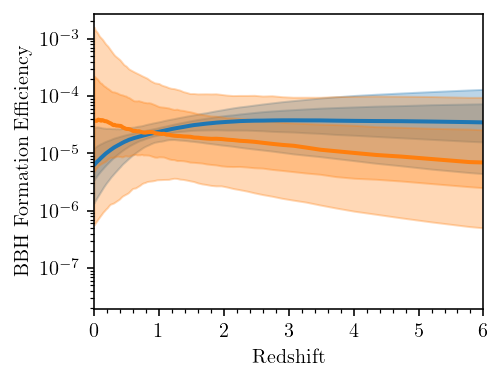

In [36]:
BBH_FR = (Rfs.T * average_Mtot).T

efficiency = BBH_FR / SFR

efficiency_prior = (Rfs_prior * 30)/ SFR


fig, ax = plt.subplots(constrained_layout=True)

plot_helper.plot_bands(ax, xs, efficiency, plot_kwargs = dict(linewidth = 2.0))

plot_helper.plot_bands(ax, xs, efficiency_prior, plot_kwargs = dict(linewidth = 2.0), color = sns.color_palette()[1])



ax.set_yscale('log')

ax.set_xlim(0,6)

ax.set_xlabel('Redshift')

ax.set_ylabel('BBH Formation Efficiency')